In [1]:
try:
    import torch  
    print('Module torch was installed')
except ImportError:    
    print("Installinng torch 1.2.0")
    !pip install -q torch==1.2.0
    import qiskit  

try:
    import torchvision  
    print('Module torchvision was installed')
except ImportError:    
    print("Installinng torchvision 0.4.0")
    !pip install -q torchvision==0.4.0
    import qiskit  

try:
    import qiskit  
    print('Module qiskit was installed')
except ImportError:    
    print("Installinng qiskit 0.13.0")
    !pip install -q qiskit==0.13.0
    import qiskit  


import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import shutil
import os
import time
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib import cm
import functools
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.extensions import XGate, UnitaryGate
from qiskit import Aer, execute
import qiskit

print = functools.partial(print, flush=True)

interest_num = [3,6]
ori_img_size = 28
img_size = 4
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1
inference_batch_size = 1


# Weiwen: modify the target classes starting from 0. Say, [3,6] -> [0,1]
def modify_target(target):
    for j in range(len(target)):
        for idx in range(len(interest_num)):
            if target[j] == interest_num[idx]:
                target[j] = idx
                break
    new_target = torch.zeros(target.shape[0],2)
    for i in range(target.shape[0]):        
        if target[i].item() == 0:            
            new_target[i] = torch.tensor([1,0]).clone()     
        else:
            new_target[i] = torch.tensor([0,1]).clone()
               
    return target,new_target

# Weiwen: select sub-set from MNIST
def select_num(dataset,interest_num):
    labels = dataset.targets #get labels
    labels = labels.numpy()
    idx = {}
    for num in interest_num:
        idx[num] = np.where(labels == num)
    fin_idx = idx[interest_num[0]]
    for i in range(1,len(interest_num)):           
        fin_idx = (np.concatenate((fin_idx[0],idx[interest_num[i]][0])),)
    
    fin_idx = fin_idx[0]    
    dataset.targets = labels[fin_idx]
    dataset.data = dataset.data[fin_idx]
    dataset.targets,_ = modify_target(dataset.targets)
    return dataset

################ Weiwen on 12-30-2020 ################
# Function: ToQuantumData from Listing 1
# Note: Coverting classical data to quantum data
######################################################
class ToQuantumData(object):
    def __call__(self, tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data = tensor.to(device)
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len, vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0,1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = torch.tensor(np.dot(u, v))
        output_data = output_matrix[:, 0].view(1, img_size,img_size)
        return output_data

################ Weiwen on 12-30-2020 ################
# Function: ToQuantumData from Listing 1
# Note: Coverting classical data to quantum matrix
######################################################
class ToQuantumMatrix(object):
    def __call__(self, tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data = tensor.to(device)
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len, vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0,1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = torch.tensor(np.dot(u, v))
        return output_matrix       
    
################ Weiwen on 12-30-2020 ################
# Function: fire_ibmq from Listing 6
# Note: used for execute quantum circuit using 
#       simulation or ibm quantum processor
# Parameters: (1) quantum circuit; 
#             (2) number of shots;
#             (3) simulation or quantum processor;
#             (4) backend name if quantum processor.
######################################################
def fire_ibmq(circuit,shots,Simulation = False,backend_name='ibmq_essex'):     
    count_set = []
    if not Simulation:
        provider = IBMQ.get_provider('ibm-q-academic')
        backend = provider.get_backend(backend_name)
    else:
        backend = Aer.get_backend('qasm_simulator')
    job_ibm_q = execute(circuit, backend, shots=shots)
    job_monitor(job_ibm_q)
    result_ibm_q = job_ibm_q.result()
    counts = result_ibm_q.get_counts()
    return counts

################ Weiwen on 12-30-2020 ################
# Function: analyze from Listing 6
# Note: used for analyze the count on states to  
#       formulate the probability for each qubit
# Parameters: (1) counts returned by fire_ibmq; 
######################################################
def analyze(counts):
    mycount = {}
    for i in range(2):
        mycount[i] = 0
    for k,v in counts.items():
        bits = len(k) 
        for i in range(bits):            
            if k[bits-1-i] == "1":
                if i in mycount.keys():
                    mycount[i] += v
                else:
                    mycount[i] = v
    return mycount,bits

################ Weiwen on 12-30-2020 ################
# Function: cccz from Listing 3
# Note: using the basic Toffoli gates and CZ gate
#       to implement cccz gate, which will flip the
#       sign of state |1111>
# Parameters: (1) quantum circuit; 
#             (2-4) control qubits;
#             (5) target qubits;
#             (6-7) auxiliary qubits.
######################################################
def cccz(circ, q1, q2, q3, q4, aux1, aux2):
    # Apply Z-gate to a state controlled by 4 qubits
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, aux1, aux2)
    circ.cz(aux2, q4)
    # cleaning the aux bits
    circ.ccx(q3, aux1, aux2)
    circ.ccx(q1, q2, aux1)
    return circ

################ Weiwen on 12-30-2020 ################
# Function: cccz from Listing 4
# Note: using the basic Toffoli gate to implement ccccx
#       gate. It is used to switch the quantum states
#       of |11110> and |11111>.
# Parameters: (1) quantum circuit; 
#             (2-5) control qubits;
#             (6) target qubits;
#             (7-8) auxiliary qubits.
######################################################
def ccccx(circ, q1, q2, q3, q4, q5, aux1, aux2):
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, q4, aux2)
    circ.ccx(aux2, aux1, q5)
    # cleaning the aux bits
    circ.ccx(q3, q4, aux2)
    circ.ccx(q1, q2, aux1)
    return circ

################ Weiwen on 12-30-2020 ################
# Function: neg_weight_gate from Listing 3
# Note: adding NOT(X) gate before the qubits associated
#       with 0 state. For example, if we want to flip 
#       the sign of |1101>, we add X gate for q2 before
#       the cccz gate, as follows.
#       --q3-----|---
#       --q2----X|X--
#       --q1-----|---
#       --q0-----z---
# Parameters: (1) quantum circuit; 
#             (2) all qubits, say q0-q3;
#             (3) the auxiliary qubits used for cccz
#             (4) states, say 1101
######################################################
def neg_weight_gate(circ,qubits,aux,state):
    idx = 0
    # The index of qubits are reversed in terms of states.
    # As shown in the above example: we put X at q2 not the third position.
    state = state[::-1]
    for idx in range(len(state)):
        if state[idx]=='0':
            circ.x(qubits[idx])
    cccz(circ,qubits[0],qubits[1],qubits[2],qubits[3],aux[0],aux[1])
    for idx in range(len(state)):
        if state[idx]=='0':
            circ.x(qubits[idx])


In [2]:
################ Weiwen on 12-30-2020 ################
# Using torch to load MNIST data
######################################################

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.Resize((ori_img_size,ori_img_size)),
                                transforms.ToTensor()])
# Path to MNIST Dataset
train_data = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

train_data = select_num(train_data,interest_num)
test_data =  select_num(test_data,interest_num)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)


Batch Id: 0, Target: tensor([1])


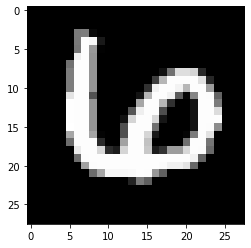

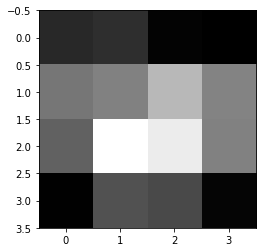

Classical Data: tensor([0.1020, 0.1137, 0.0275, 0.0196, 0.2588, 0.2824, 0.3922, 0.2863, 0.2196,
        0.5373, 0.4980, 0.2824, 0.0235, 0.1843, 0.1686, 0.0314])
Quantum Data: tensor([0.0957, 0.1067, 0.0258, 0.0184, 0.2429, 0.2650, 0.3680, 0.2687, 0.2061,
        0.5042, 0.4674, 0.2650, 0.0221, 0.1730, 0.1582, 0.0294],
       dtype=torch.float64)


In [3]:
################ Weiwen on 12-30-2020 ################
# T1: Downsample the image from 28*28 to 4*4
# T2: Convert classical data to quantum data which 
#     can be encoded to the quantum states (amplitude)
######################################################

# Process data by hand, we can also integrate ToQuantumData into transform
def data_pre_pro(img):
    # Print original figure
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    
    plt.show()
    # Print resized figure
    image = np.asarray(npimg[0] * 255, np.uint8)    
    im = Image.fromarray(image,mode="L")
    im = im.resize((4,4),Image.BILINEAR)    
    plt.imshow(im,cmap='gray',)
    plt.show()
    # Converting classical data to quantum data
    trans_to_tensor = transforms.ToTensor()
    trans_to_vector = ToQuantumData()
    trans_to_matrix = ToQuantumMatrix()    
    print("Classical Data: {}".format(trans_to_tensor(im).flatten()))
    print("Quantum Data: {}".format(trans_to_vector(trans_to_tensor(im)).flatten()))
    return trans_to_matrix(trans_to_tensor(im)),trans_to_vector(trans_to_tensor(im))

# Use the first image from test loader as example
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data))
    break

In [4]:
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################

# Model initialization
weight_1_1 = torch.tensor([1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])

weight_2_1 = torch.tensor([1.,  -1.])
norm_flag_1 = True
norm_para_1 = torch.tensor(0.3060)

weight_2_2 = torch.tensor([-1.,  -1.])
norm_flag_2 = False
norm_para_2 = torch.tensor(0.6940)

In [5]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation
######################################################

# From Listing 2: creat the qubits to hold data
inp_1 = QuantumRegister(4,"in1_qbit")
inp_2 = QuantumRegister(4,"in2_qbit")
circ = QuantumCircuit(inp_1,inp_2)
data_matrix = quantum_matrix
circ.append(UnitaryGate(data_matrix, label="Input"), inp_1[0:4])
circ.append(UnitaryGate(data_matrix, label="Input"), inp_2[0:4])

# From Listing 3: create auxiliary qubits
aux = QuantumRegister(2,"aux_qbit")
circ.add_register(aux)

# From Listing 4: create output qubits for the first layer (hidden neurons)
hidden_neurons = QuantumRegister(2,"hidden_qbits")
circ.add_register(hidden_neurons)


# From Listing 3: to multiply inputs and weights on quantum circuit
if weight_1_1.sum()<0:
    weight_1_1 = weight_1_1*-1
idx = 0
for idx in range(weight_1_1.flatten().size()[0]):
    if weight_1_1[idx]==-1:
        state = "{0:b}".format(idx).zfill(4)
        neg_weight_gate(circ,inp_1,aux,state)
        circ.barrier()

if weight_1_2.sum()<0:
    weight_1_2 = weight_1_2*-1
idx = 0
for idx in range(weight_1_2.flatten().size()[0]):
    if weight_1_2[idx]==-1:
        state = "{0:b}".format(idx).zfill(4)
        neg_weight_gate(circ,inp_2,aux,state)
        circ.barrier()
        
# From Listing 4: applying the quadratic function on the weighted sum
circ.h(inp_1)
circ.x(inp_1)
ccccx(circ,inp_1[0],inp_1[1],inp_1[2],inp_1[3],hidden_neurons[0],aux[0],aux[1])

circ.h(inp_2)
circ.x(inp_2)
ccccx(circ,inp_2[0],inp_2[1],inp_2[2],inp_2[3],hidden_neurons[1],aux[0],aux[1])


print("Hidden layer created!")

Hidden layer created!


In [6]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf
######################################################

inter_q_1 = QuantumRegister(1,"inter_q_1_qbits")
norm_q_1 = QuantumRegister(1,"norm_q_1_qbits")
out_q_1 = QuantumRegister(1,"out_q_1_qbits")
circ.add_register(inter_q_1,norm_q_1,out_q_1)

circ.barrier()

if weight_2_1.sum()<0:
    weight_2_1 = weight_2_1*-1
idx = 0
for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        circ.x(hidden_neurons[idx])
circ.h(inter_q_1)
circ.cz(hidden_neurons[0],inter_q_1)
circ.x(inter_q_1)
circ.cz(hidden_neurons[1],inter_q_1)
circ.x(inter_q_1)
circ.h(inter_q_1)
circ.x(inter_q_1)

circ.barrier()

norm_init_rad = float(norm_para_1.sqrt().arcsin()*2)
circ.ry(norm_init_rad,norm_q_1)
if norm_flag_1:
    circ.cx(inter_q_1,out_q_1)
    circ.x(inter_q_1)
    circ.ccx(inter_q_1,norm_q_1,out_q_1)
else:
    circ.ccx(inter_q_1,norm_q_1,out_q_1)

for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        circ.x(hidden_neurons[idx])

circ.barrier()




inter_q_2 = QuantumRegister(1,"inter_q_2_qbits")
norm_q_2 = QuantumRegister(1,"norm_q_2_qbits")
out_q_2 = QuantumRegister(1,"out_q_2_qbits")
circ.add_register(inter_q_2,norm_q_2,out_q_2)

circ.barrier()

if weight_2_2.sum()<0:
    weight_2_2 = weight_2_2*-1
idx = 0
for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        circ.x(hidden_neurons[idx])
circ.h(inter_q_2)
circ.cz(hidden_neurons[0],inter_q_2)
circ.x(inter_q_2)
circ.cz(hidden_neurons[1],inter_q_2)
circ.x(inter_q_2)
circ.h(inter_q_2)
circ.x(inter_q_2)

circ.barrier()

norm_init_rad = float(norm_para_2.sqrt().arcsin()*2)
circ.ry(norm_init_rad,norm_q_2)
if norm_flag_2:
    circ.cx(inter_q_2,out_q_2)
    circ.x(inter_q_2)
    circ.ccx(inter_q_2,norm_q_2,out_q_2)
else:
    circ.ccx(inter_q_2,norm_q_2,out_q_2)

for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        circ.x(hidden_neurons[idx])

circ.barrier()

c_reg = ClassicalRegister(2,"reg")
circ.add_register(c_reg)
circ.measure(out_q_1,c_reg[0])
circ.measure(out_q_2,c_reg[1])

print("Output layer created!")

Output layer created!


In [7]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################

# From Listing 6: execute the quantum circuit to obtain the results
qc_shots=8192
counts = fire_ibmq(circ,qc_shots,True)
(mycount,bits) = analyze(counts)
class_prob=[]
for b in range(bits):
    class_prob.append(float(mycount[b])/qc_shots)


Job Status: job has successfully run


In [8]:
print(class_prob)
print("Prediction class: {}".format(class_prob.index(max(class_prob))))
print("Target class: {}".format(target[0]))
if class_prob.index(max(class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")

[0.463134765625, 0.5321044921875]
Prediction class: 1
Target class: 1
Correct prediction
